In [63]:
from os import listdir
from os.path import isfile, join
import cv2
from matplotlib import pyplot as plt
import kerem
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 30]

root_path = '../datasets/'
file_names = [f for f in listdir(root_path) if isfile(join(root_path, f))]

image_storage = dict()

for file_name in file_names:
    image_storage[file_name.split('.')[0]] = cv2.imread(root_path + file_name)

In [64]:
cv2.__version__

'4.5.2'

In [65]:

img1 = image_storage['mf00']
img2 = image_storage['wf']

img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
#img1 = kerem.downsize_image(img1, 20)
#img1 = kerem.upsize_image(img1, 20)


plt.imshow(img1)

temp = kerem.resize_image(img1, 10)

plt.imshow(temp)


#kerem.show_images([kerem.resize_image(img1,3), kerem.resize_image(img2,3)])
kerem.show_images([img1, img2])

In [66]:
sift =cv2.SIFT_create(
    nfeatures=100,
    #nOctaveLayers=..., 
    #contrastThreshold=..., 
    #edgeThreshold=..., 
    #sigma=...
)
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


In [77]:
sift.defaultNorm()

4

In [78]:
sift.descriptorSize()

128

In [79]:
sift.descriptorType()

5

In [67]:
print(len(kp1))
print(len(kp2))

946
5878


In [68]:
print(des1.shape)
print(des2.shape)

(946, 128)
(5878, 128)


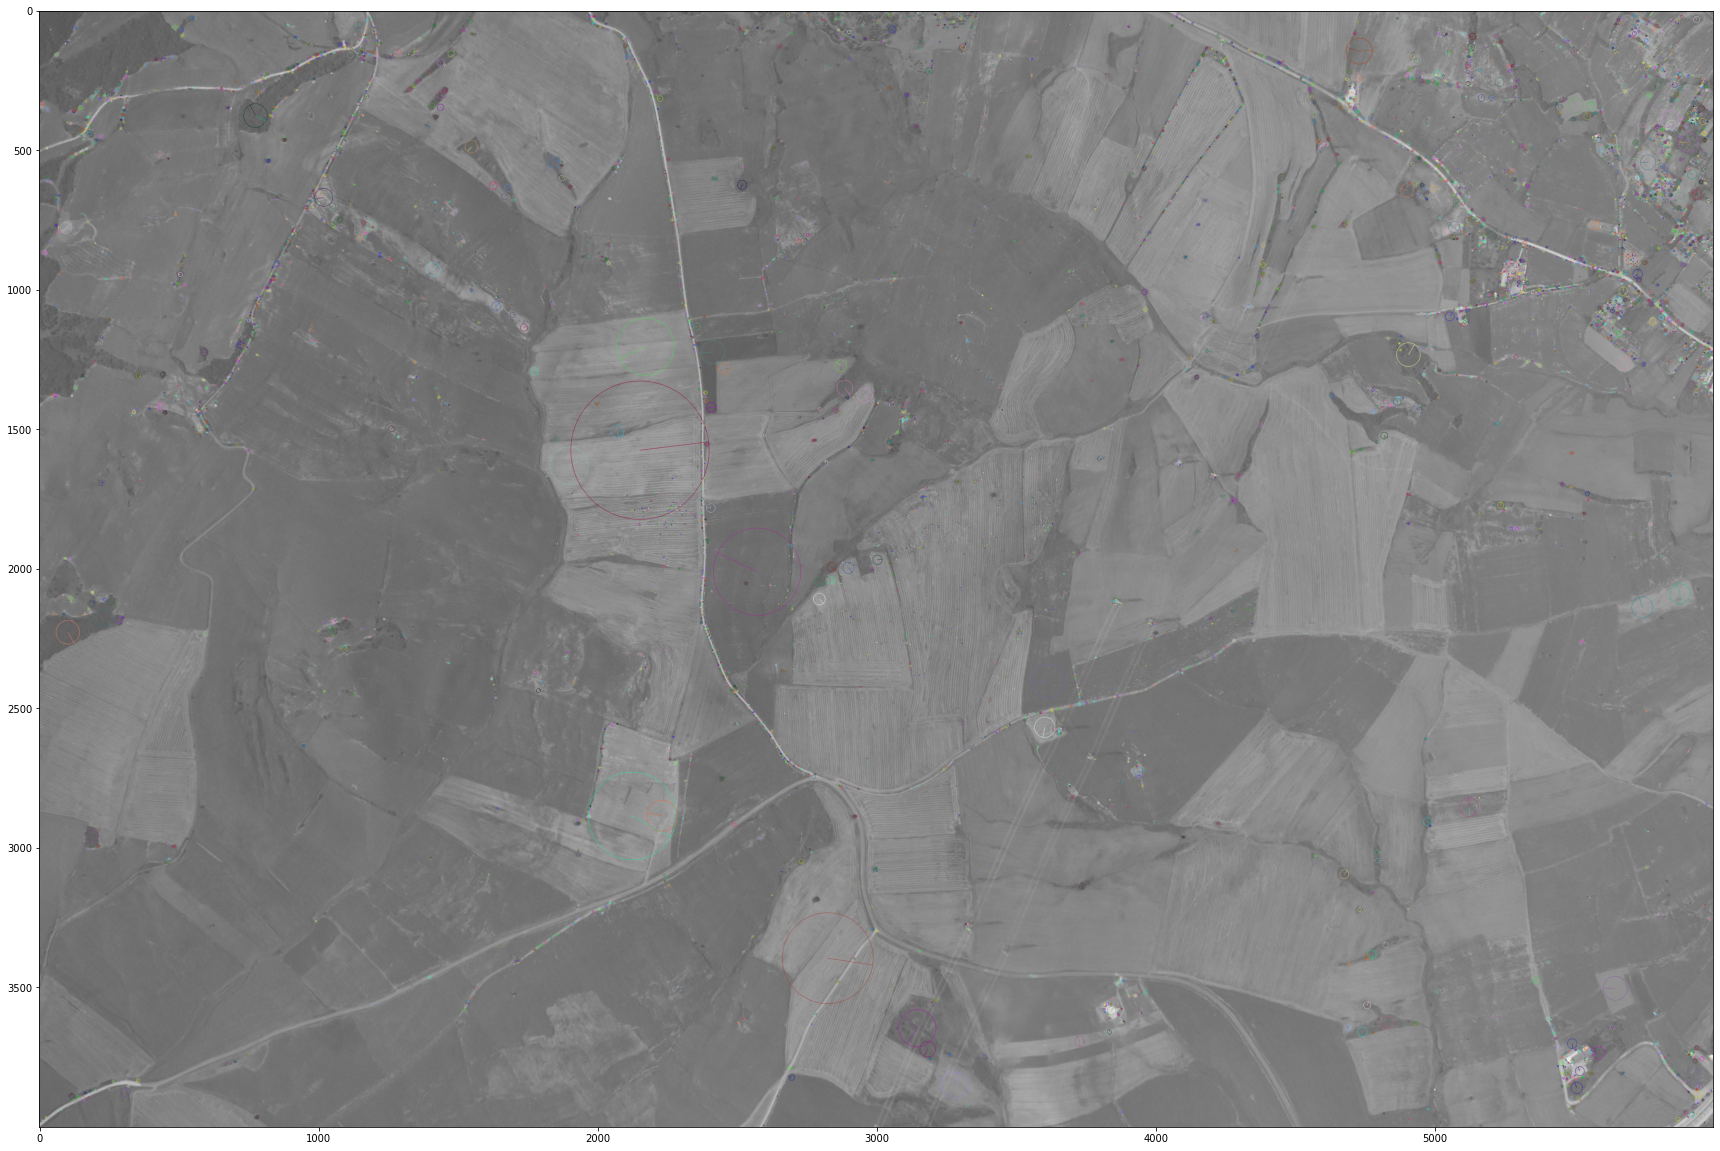

In [69]:
plt.imshow(cv2.drawKeypoints(img2_gray,kp2,img2,flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS))

In [70]:
plt.imshow(cv2.drawKeypoints(img1_gray,kp1,img1,flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS))

In [35]:

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)


In [36]:

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [37]:
len(good)

4

In [38]:

MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w,d = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None


Not enough matches are found - 4/10


In [39]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3),plt.show()


(<matplotlib.image.AxesImage at 0x7f1460df1760>, None)

cv2.imwrite('../results/mf00.JPG', img3)

In [ ]:
kerem.show_images(
    [img3],
    divided_by=6
)